## Gaussian fits
In this notebook, distributions of geometric quantities obtained from AMBER minimizations are plotted and fitted with gaussian distributions to extract relevant features to possibly add prior knowledge to the loss function used for parameters optimization. The nature of the distribution used (unimodal or multimodal) reflects the parametrization in HiRE model: while it gives in general good results for bonds, it fails to reproduce the correct distributions for most of angles and torsions.

In [1]:
import mdtraj as md
import numpy as np
import sys
import pickle
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import FormatStrFormatter
from sklearn.mixture import GaussianMixture
from matplotlib import rc
import matplotlib.backends.backend_pdf
from os.path import exists
from os.path import getsize
import math
from cmath import rect, phase
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

plt.style.use('default')
plt.rcParams["font.family"] = "serif"
rc('text.latex', preamble=r'\usepackage{cmbright}')

In [13]:
# functions to obtain subplots

def choose_subplot_dimensions(k):
    if k < 5:
        return k, 1
    elif k < 11:
        return math.ceil(k/3), 4
    else:
        # I've chosen to have a maximum of 3 columns
        return math.ceil(k/4), 4


def generate_subplots(k, row_wise=False):
    nrow, ncol = choose_subplot_dimensions(k)
    # Choose your share X and share Y parameters as you wish:
    figure, axes = plt.subplots(nrow, ncol,
                                sharex=False,
                                sharey=False,
                                figsize=(17,17))  # (17,17) for dihedrals, (17,10) for angles and bonds

    # Check if it's an array. If there's only one plot, it's just an Axes obj
    if not isinstance(axes, np.ndarray):
        return figure, [axes]
    else:
        # Choose the traversal you'd like: 'F' is col-wise, 'C' is row-wise
        axes = axes.flatten(order=('C' if row_wise else 'F'))

        # Delete any unused axes from the figure, so that they don't show
        # blank x- and y-axis lines
        for idx, ax in enumerate(axes[k:]):
            figure.delaxes(ax)

            # Turn ticks on for the last ax in each column, wherever it lands
            idx_to_turn_on_ticks = idx + k - ncol if row_wise else idx + k - 1
            for tk in axes[idx_to_turn_on_ticks].get_xticklabels():
                tk.set_visible(True)

        axes = axes[:k]
        return figure, axes

In [3]:
# load AMBER distributions
bonds = pickle.load(open('Amber/bonds.pkl','rb'))
angles = pickle.load(open('Amber/angles.pkl','rb'))
dihedrals = pickle.load(open('Amber/dihedrals.pkl','rb'))

P-O: mu = 1.608, sigma=0.005
O-C: mu = 1.422, sigma=0.003
C-R4: mu = 1.537, sigma=0.004
R4-P: mu = 3.847, sigma=0.183
R4-R1: mu = 2.331, sigma=0.016
R1-C1: mu = 3.034, sigma=0.006
R1-U1: mu = 3.099, sigma=0.008
R1-A1: mu = 2.657, sigma=0.005
R1-G1: mu = 2.659, sigma=0.005
A1-A2: mu = 2.230, sigma=0.003
G1-G2: mu = 2.486, sigma=0.002


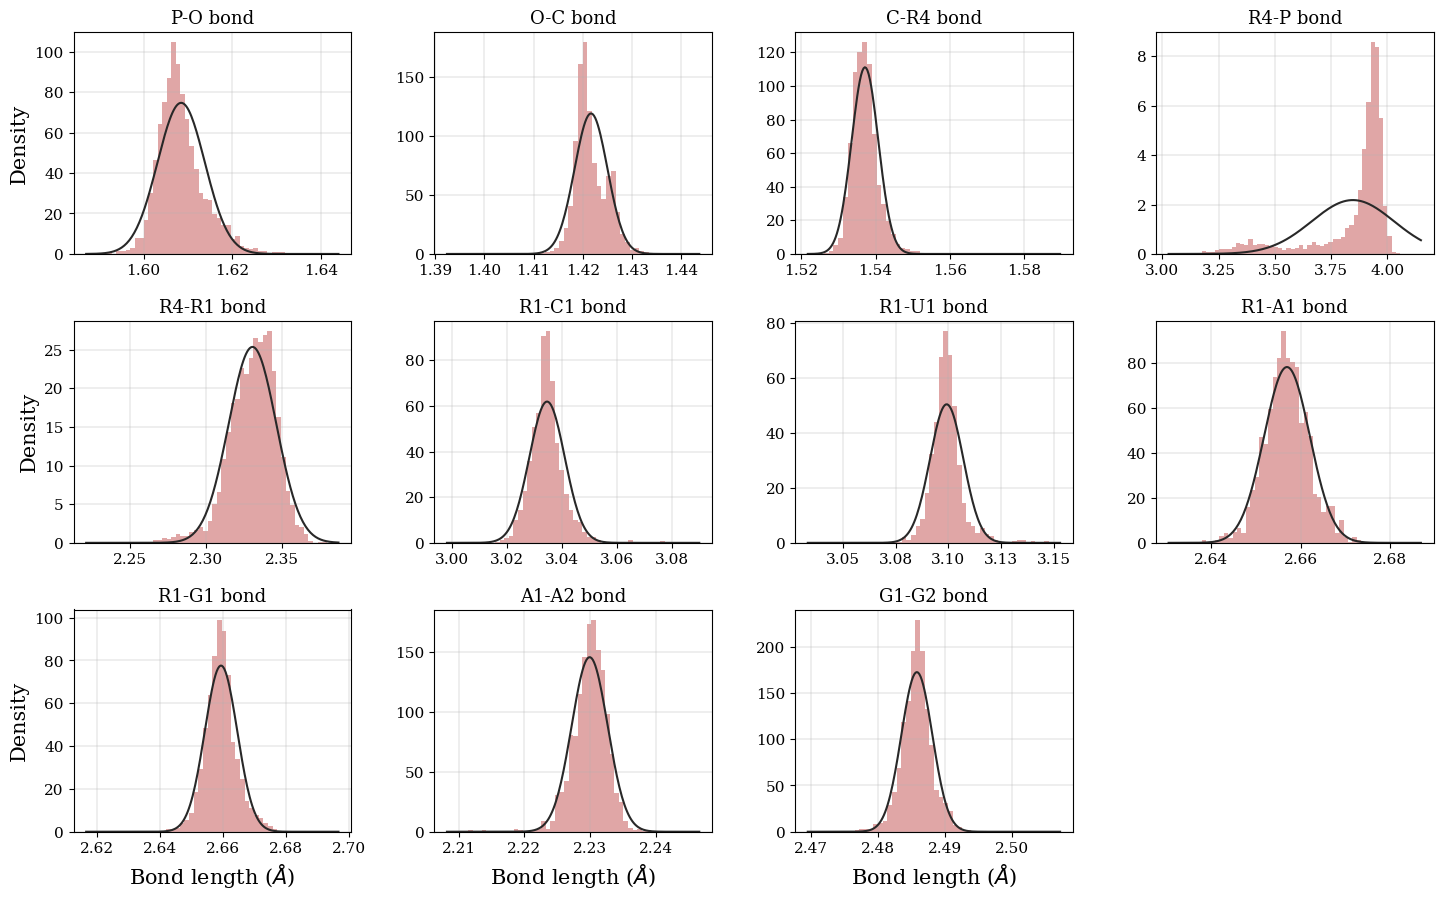

In [10]:
# plot and fit bonds

kde_kws = {'shade': True, 'alpha':0.3, 'linewidth': 1, 'bw':0.05}
bonds_gausspar = []

figure, axes = generate_subplots(len(bonds), row_wise=True)
for i, key in enumerate(bonds):
    x = np.array(bonds[key])*10
    sns.distplot(ax = axes[i], x=x, hist = True, kde = False, fit=stats.norm,
        kde_kws = {'shade': True, 'alpha':0.1, 'linewidth': 2, 'bw':0.1, 'linestyle':'--'}, color='firebrick')
    (mu,sigma) = stats.norm.fit(x)
    bonds_gausspar.append([mu,sigma])
    print("{0}: mu = {1:.3f}, sigma={2:.3f}".format(key,mu,sigma))
    axes[i].set_title(key+' bond', fontsize=13)
    axes[i].set_ylabel('')
    axes[i].grid(linewidth=0.3)
    # axes[i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axes[i].xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    # axes[i].yaxis.set_major_formatter(NullFormatter())
    axes[i].tick_params(axis='both', which='major', labelsize=11)
    # axes[i].tick_params(axis='y', which='major', left=False, right=False)
    axes[i].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))


plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)
axes[8].set_xlabel(r'Bond length ($\AA$)',fontsize=15)
axes[9].set_xlabel(r'Bond length ($\AA$)',fontsize=15)
axes[10].set_xlabel(r'Bond length ($\AA$)',fontsize=15)

axes[0].set_ylabel('Density',fontsize=15)
axes[4].set_ylabel('Density',fontsize=15)
axes[8].set_ylabel('Density',fontsize=15)

perm = (3,4,8,7,6,5,10,9,2,0,1)
bonds_gausspar = [bonds_gausspar[i] for i in perm]
bonds_gausspar = np.array(bonds_gausspar)
np.save('../Models/Model_with_tanh/data/bonds_gausspar', bonds_gausspar)

R4-R1-A1: mu = 2.167, sigma=0.130
R4-R1-U1: mu = 2.344, sigma=0.119
R4-R1-G1: mu = 2.167, sigma=0.119
R4-R1-C1: mu = 2.337, sigma=0.096
R1-A1-A2: mu = 2.012, sigma=0.009
R1-G1-G2: mu = 1.928, sigma=0.012
P-O-C: mu = 2.125, sigma=0.015
O-C-R4: mu = 1.957, sigma=0.024
C-R4-P: mu = 1.801, sigma=0.197
R4-P-O: mu = 1.858, sigma=0.187
C-R4-R1: mu = 2.360, sigma=0.119
R1-R4-P: mu = 1.727, sigma=0.119


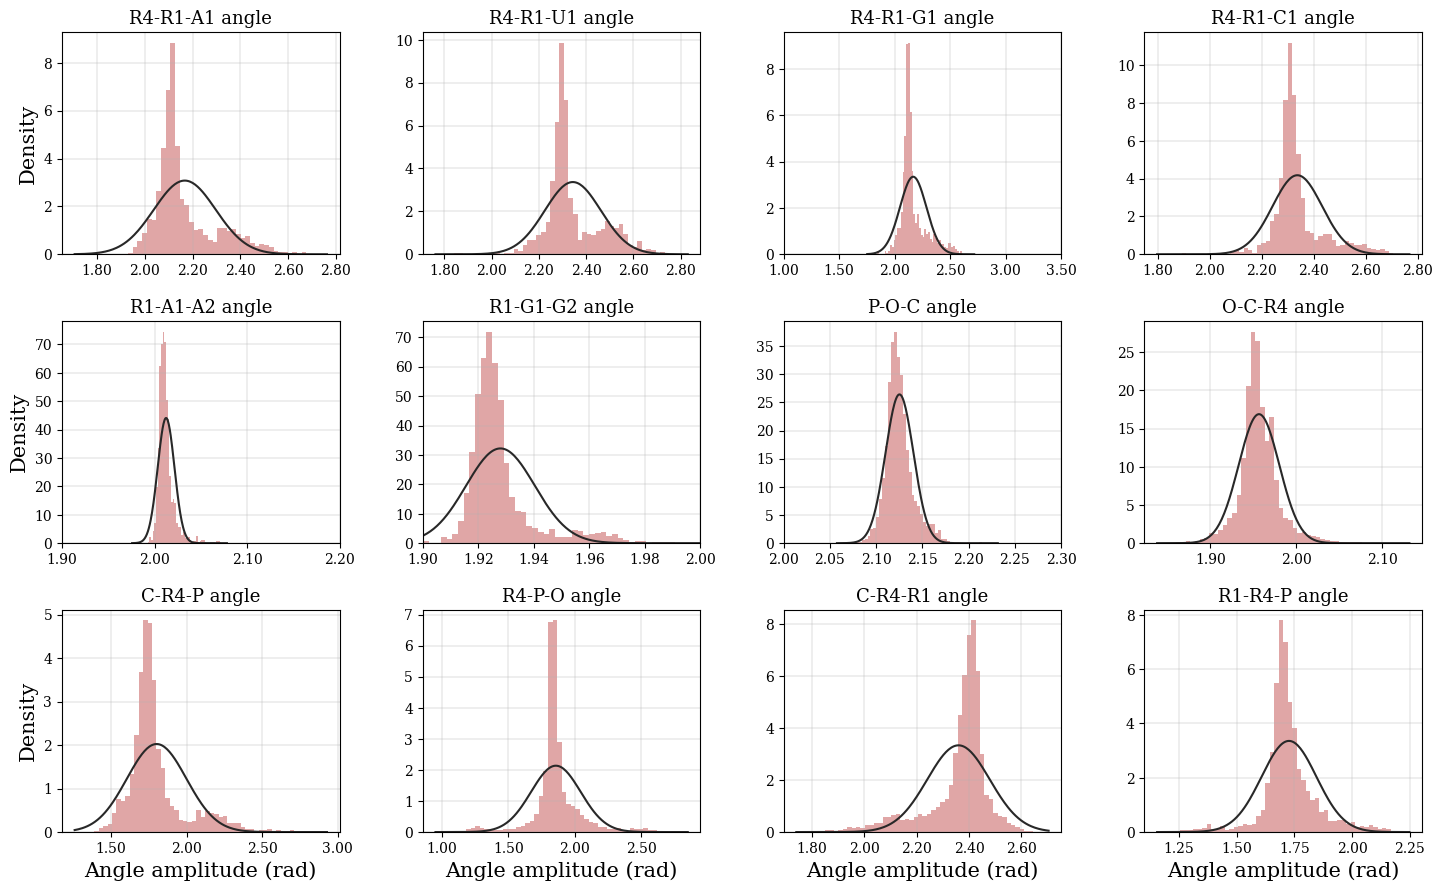

In [12]:
# plot and fit angles

kde_kws = {'shade': True, 'alpha':0.3, 'linewidth': 1, 'bw':0.1}
angles_gausspar = []

figure, axes = generate_subplots(len(angles), row_wise=True)
for i, key in enumerate(angles):
    sns.distplot(ax = axes[i], x=angles[key], hist = True, kde = False,
        kde_kws = {'shade': True, 'alpha':0.1, 'linewidth': 2, 'bw':0.1, 'linestyle':'--'},
                 color='firebrick', fit=stats.norm)
    (mu,sigma) = stats.norm.fit(angles[key])
    angles_gausspar.append([mu,sigma])
    print("{0}: mu = {1:.3f}, sigma={2:.3f}".format(key,mu,sigma))
    axes[i].set_title(key+' angle', fontsize=13)
    axes[i].set_ylabel('')
    axes[i].grid(linewidth=0.3)
    # axes[i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axes[i].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

axes[2].set_xlim([1,3.5])
axes[4].set_xlim([1.9,2.2])
axes[5].set_xlim([1.9,2])
axes[6].set_xlim([2,2.3])

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)

axes[8].set_xlabel('Angle amplitude (rad)',fontsize=15)
axes[9].set_xlabel('Angle amplitude (rad)',fontsize=15)
axes[10].set_xlabel('Angle amplitude (rad)',fontsize=15)
axes[11].set_xlabel('Angle amplitude (rad)',fontsize=15)

axes[0].set_ylabel('Density',fontsize=15)
axes[4].set_ylabel('Density',fontsize=15)
axes[8].set_ylabel('Density',fontsize=15)

angles_gausspar = np.array(angles_gausspar)
np.save('../Models/Model_with_tanh/data/angles_gausspar', angles_gausspar)

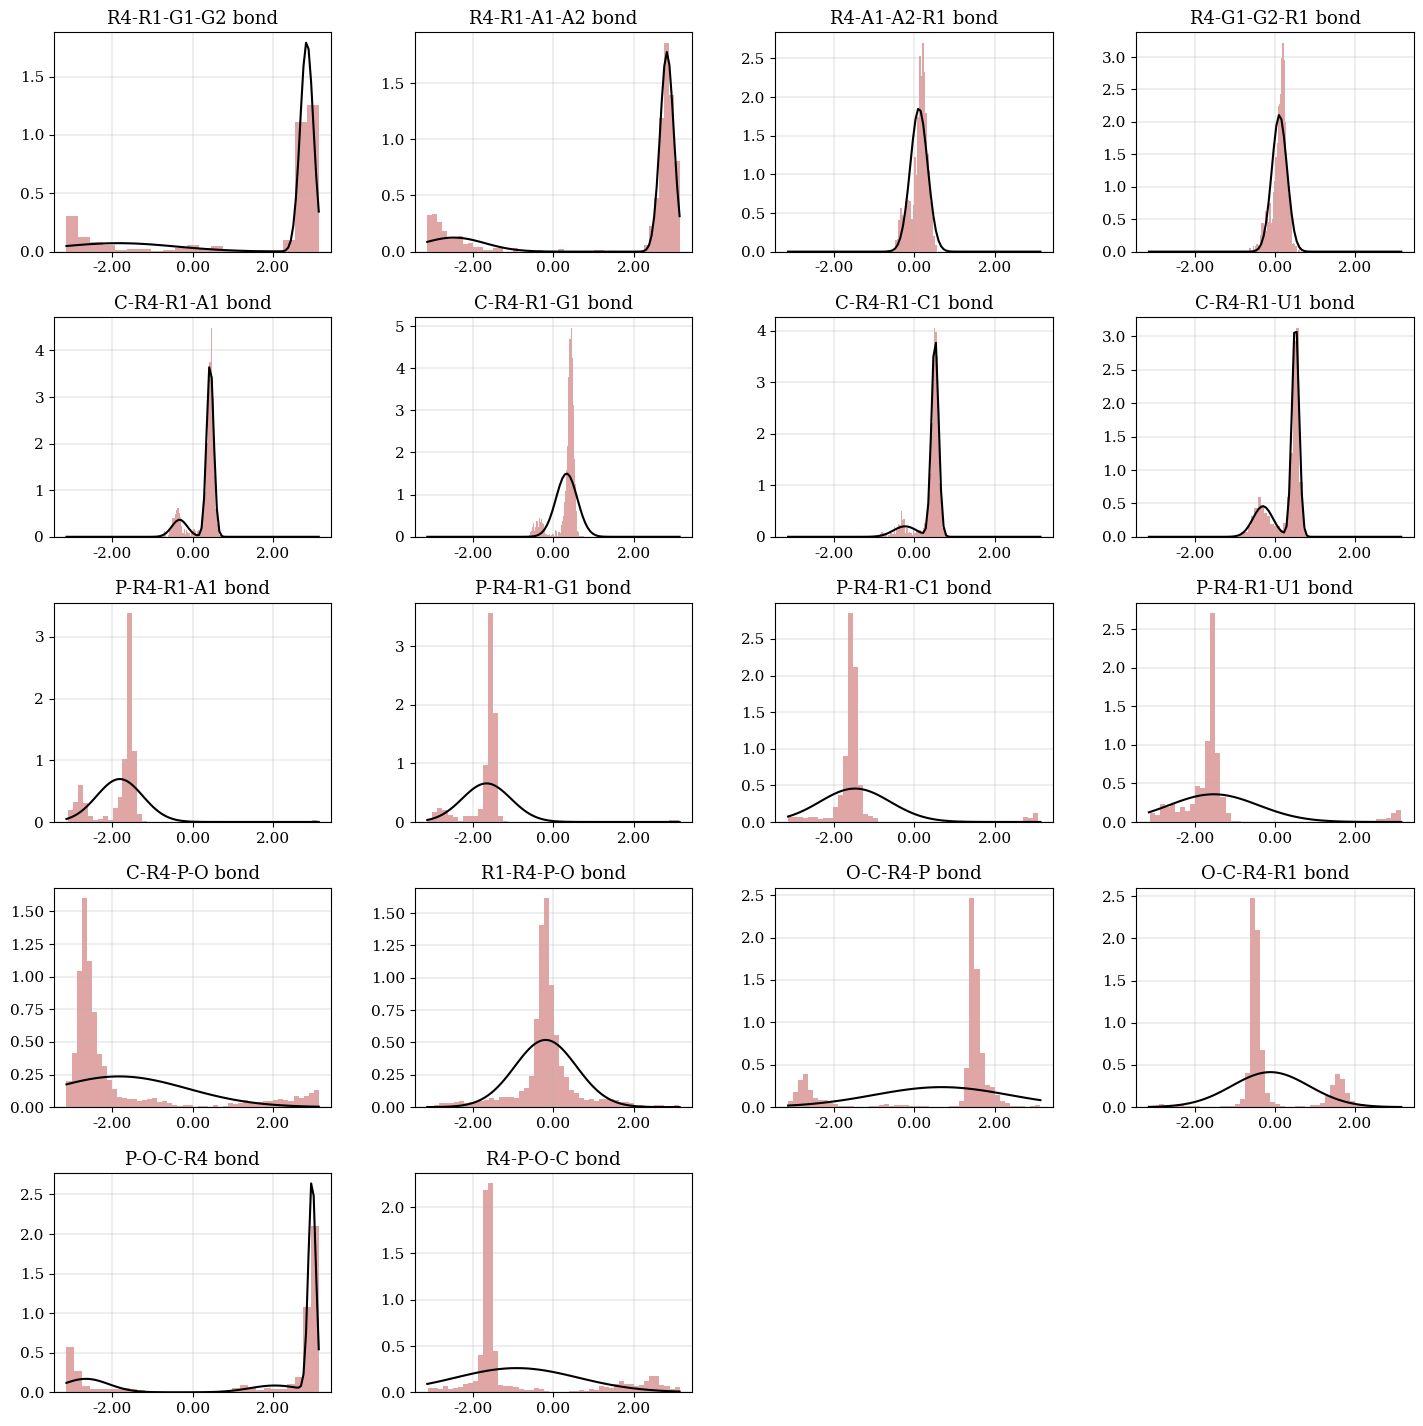

In [17]:
# plot and fit dihedrals: most of the distributions are multimodal

kde_kws = {'shade': True, 'alpha':0.3, 'linewidth': 1, 'bw':0.05}
dihedrals_gausspar = []
x_range = np.linspace(-np.pi,np.pi,100)
n_components = [2,2,1,1,2,1,2,2,1,1,1,1,1,1,1,1,3,1]  
# reflects the number of components of the mixtures in the HiRE model

def gaussian_mixture_fit(x,weights,means,variances):
    n_components = len(weights)
    y = 0
    for i in range(n_components):
        y += weights[i]*(1/(2*np.pi*variances[i])**0.5)*np.exp(-(x-means[i])**2/(2*variances[i]))
    return y

figure, axes = generate_subplots(len(dihedrals), row_wise=True)
for i, key in enumerate(dihedrals):
    x = np.array(dihedrals[key])
    sns.distplot(ax = axes[i], x=x, hist = True, kde = False, norm_hist=True,
        kde_kws = {'shade': True, 'alpha':0.1, 'linewidth': 2, 'bw':0.1, 'linestyle':'--'},
                 label='Amber', color='firebrick')
    gm = GaussianMixture(n_components=n_components[i],covariance_type='diag').fit(x.reshape(-1,1))
    axes[i].plot(x_range,gaussian_mixture_fit(x_range,gm.weights_,gm.means_,gm.covariances_), c='black')
    for j in range(n_components[i]):
        dihedrals_gausspar.append([float(gm.means_[j]),float(gm.covariances_[j]**0.5)])
    axes[i].set_title(key+' bond', fontsize=13)
    axes[i].set_ylabel('')
    axes[i].grid(linewidth=0.3)
    # axes[i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axes[i].xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    # axes[i].yaxis.set_major_formatter(NullFormatter())
    axes[i].tick_params(axis='both', which='major', labelsize=11)
    # axes[i].tick_params(axis='y', which='major', left=False, right=False)
    axes[i].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))


plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)


dihedrals_gausspar = np.array(dihedrals_gausspar)
np.save('../Models/Model_with_tanh/data/dihedrals_gausspar', dihedrals_gausspar)